In [27]:
import pandas as pd
import numpy as np
import sklearn.decomposition
from scipy import stats
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

import genpy

In [2]:
# Specify the genotypes
single_mutants = ['b', 'c', 'd', 'e']
double_mutants = {'a' : 'bc', 'f':'bd'}

In [3]:
genmap = pd.read_csv('../input/library_genotype_mapping.txt', comment='#')
genmap.genotype = genmap.genotype.apply(str)
genmap.genotype = genmap.genotype.apply(str.lower) # make sure everything is always in lowercase


In [4]:
# Make all possible combinations of WT, X
combs = []
for gene in genmap.genotype.unique():
    if gene != 'wt':
        combs += [['WT', gene]]

In [5]:
# get all pandas tpm dataframes for each project
# tpm files are in kallisto_loc
kallisto_loc = '../input/kallisto_all/'

tpm = {}  # initialize an empty hash

# get tpm for each project
for prjct in genmap.project_name.unique():
    tpm[prjct] = pd.read_csv(kallisto_loc + prjct +'/kallisto/abundance.tsv', sep='\t')
    tpm[prjct].sort_values('target_id', inplace=True)

In [6]:
# load all the beta values for each genotype:
sleuth_loc = '../sleuth/'

beta = {}  # empty hash

# get betas for each genotype comparison:
for comb in combs:
    c = comb[0] + '_' + comb[1]
    beta[comb[1]] = pd.read_csv(sleuth_loc + c + '/betas.csv')
    
    # beta dataframes from sleuth MUST BE SORTED By ID!!!!
    # if you don't do this, nothing works!
    beta[comb[1]].sort_values('target_id', inplace=True)

In [29]:
# PCA
pca_matrix = genpy.make_matrix(tpm, genmap, 'project_name', 'tpm')
sklearn_pca, n = genpy.pca(pca_matrix)

The first 4 principal components explain >=90% of the data


In [30]:
# keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# add a sample and genotype column
df_nD['samples'] = genmap.project_name.unique()
l = lambda x: genmap[genmap.project_name == x].genotype.values[0]
df_nD['genotypes'] = df_nD.samples.apply(l)
df_nD.head()

,PCA1,PCA2,PCA3,PCA4,samples,genotypes
0,-7597.070087,-2748.583552,-3246.871740,1290.455581,Project_17434_indexN704-N517,wt
1,11507.253519,-2051.481912,-1497.092629,-3054.503202,Project_17441_indexN704-N508,a
2,-3499.905323,5120.560035,-2885.212424,3672.694861,Project_17448_indexN705-N507,d
3,-7673.426882,-2525.724491,-1947.520648,5304.474756,Project_17435_indexN704-N502,wt
4,10090.924838,-3448.230513,-2854.242845,-456.802389,Project_17442_indexN705-N517,a


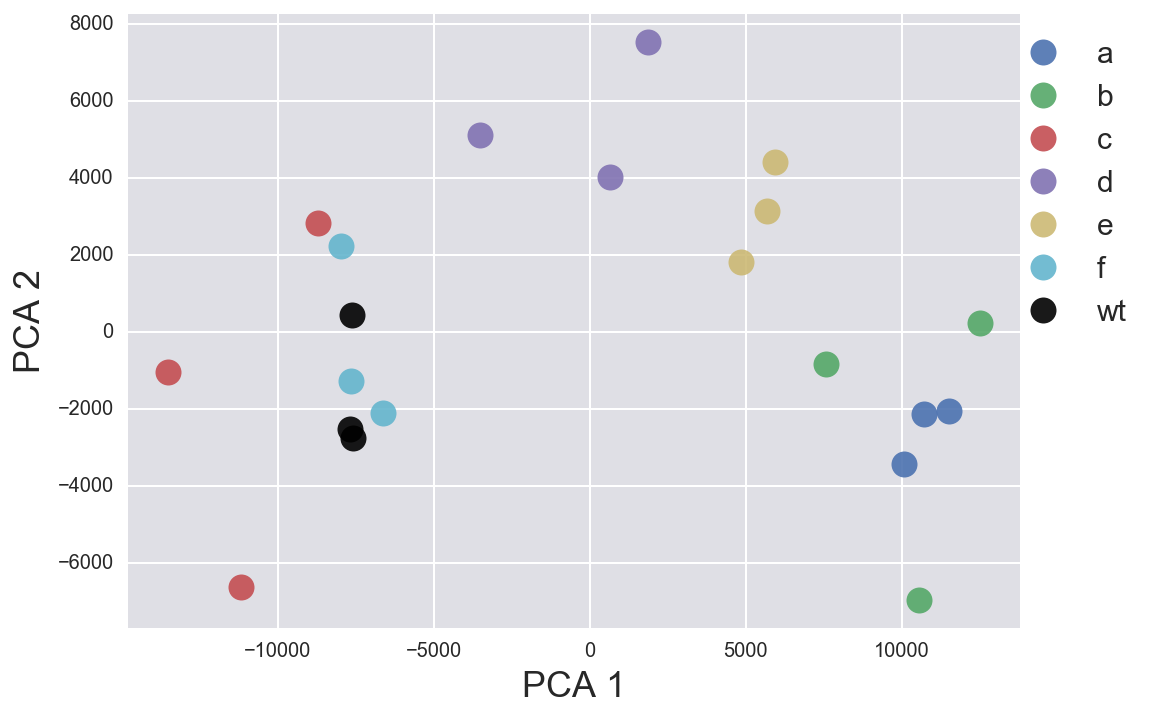

In [31]:
def plot_2d_pca(df_pca, group_col, special_key, save=''):
    """
    Very basic wrapper around plt.plot to plot pca results after using tidy_pca.
    
    df_pca - df output by tidy_pca
    group_col - column in df_pca to group by
    special_key - if there's a particular group to color in black, use special_key
                  to identify it
    
    returns:
    a matplotlib object
    """
    # plot first 2d components! 
    for key, group in df_nD.groupby(group_col):
        if key == special_key:
            plt.plot(group.PCA1, group.PCA2, 'ko', alpha=0.9, label=key, ms=13)
        else:
            plt.plot(group.PCA1, group.PCA2, 'o', alpha=.9, label=key, ms=13)

    # Tidy up plot
    plt.legend(bbox_to_anchor=(1.15, 1), fontsize=15)
    plt.margins(0.05)
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    
    if save:
        plt.savefig(save)
    
    
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

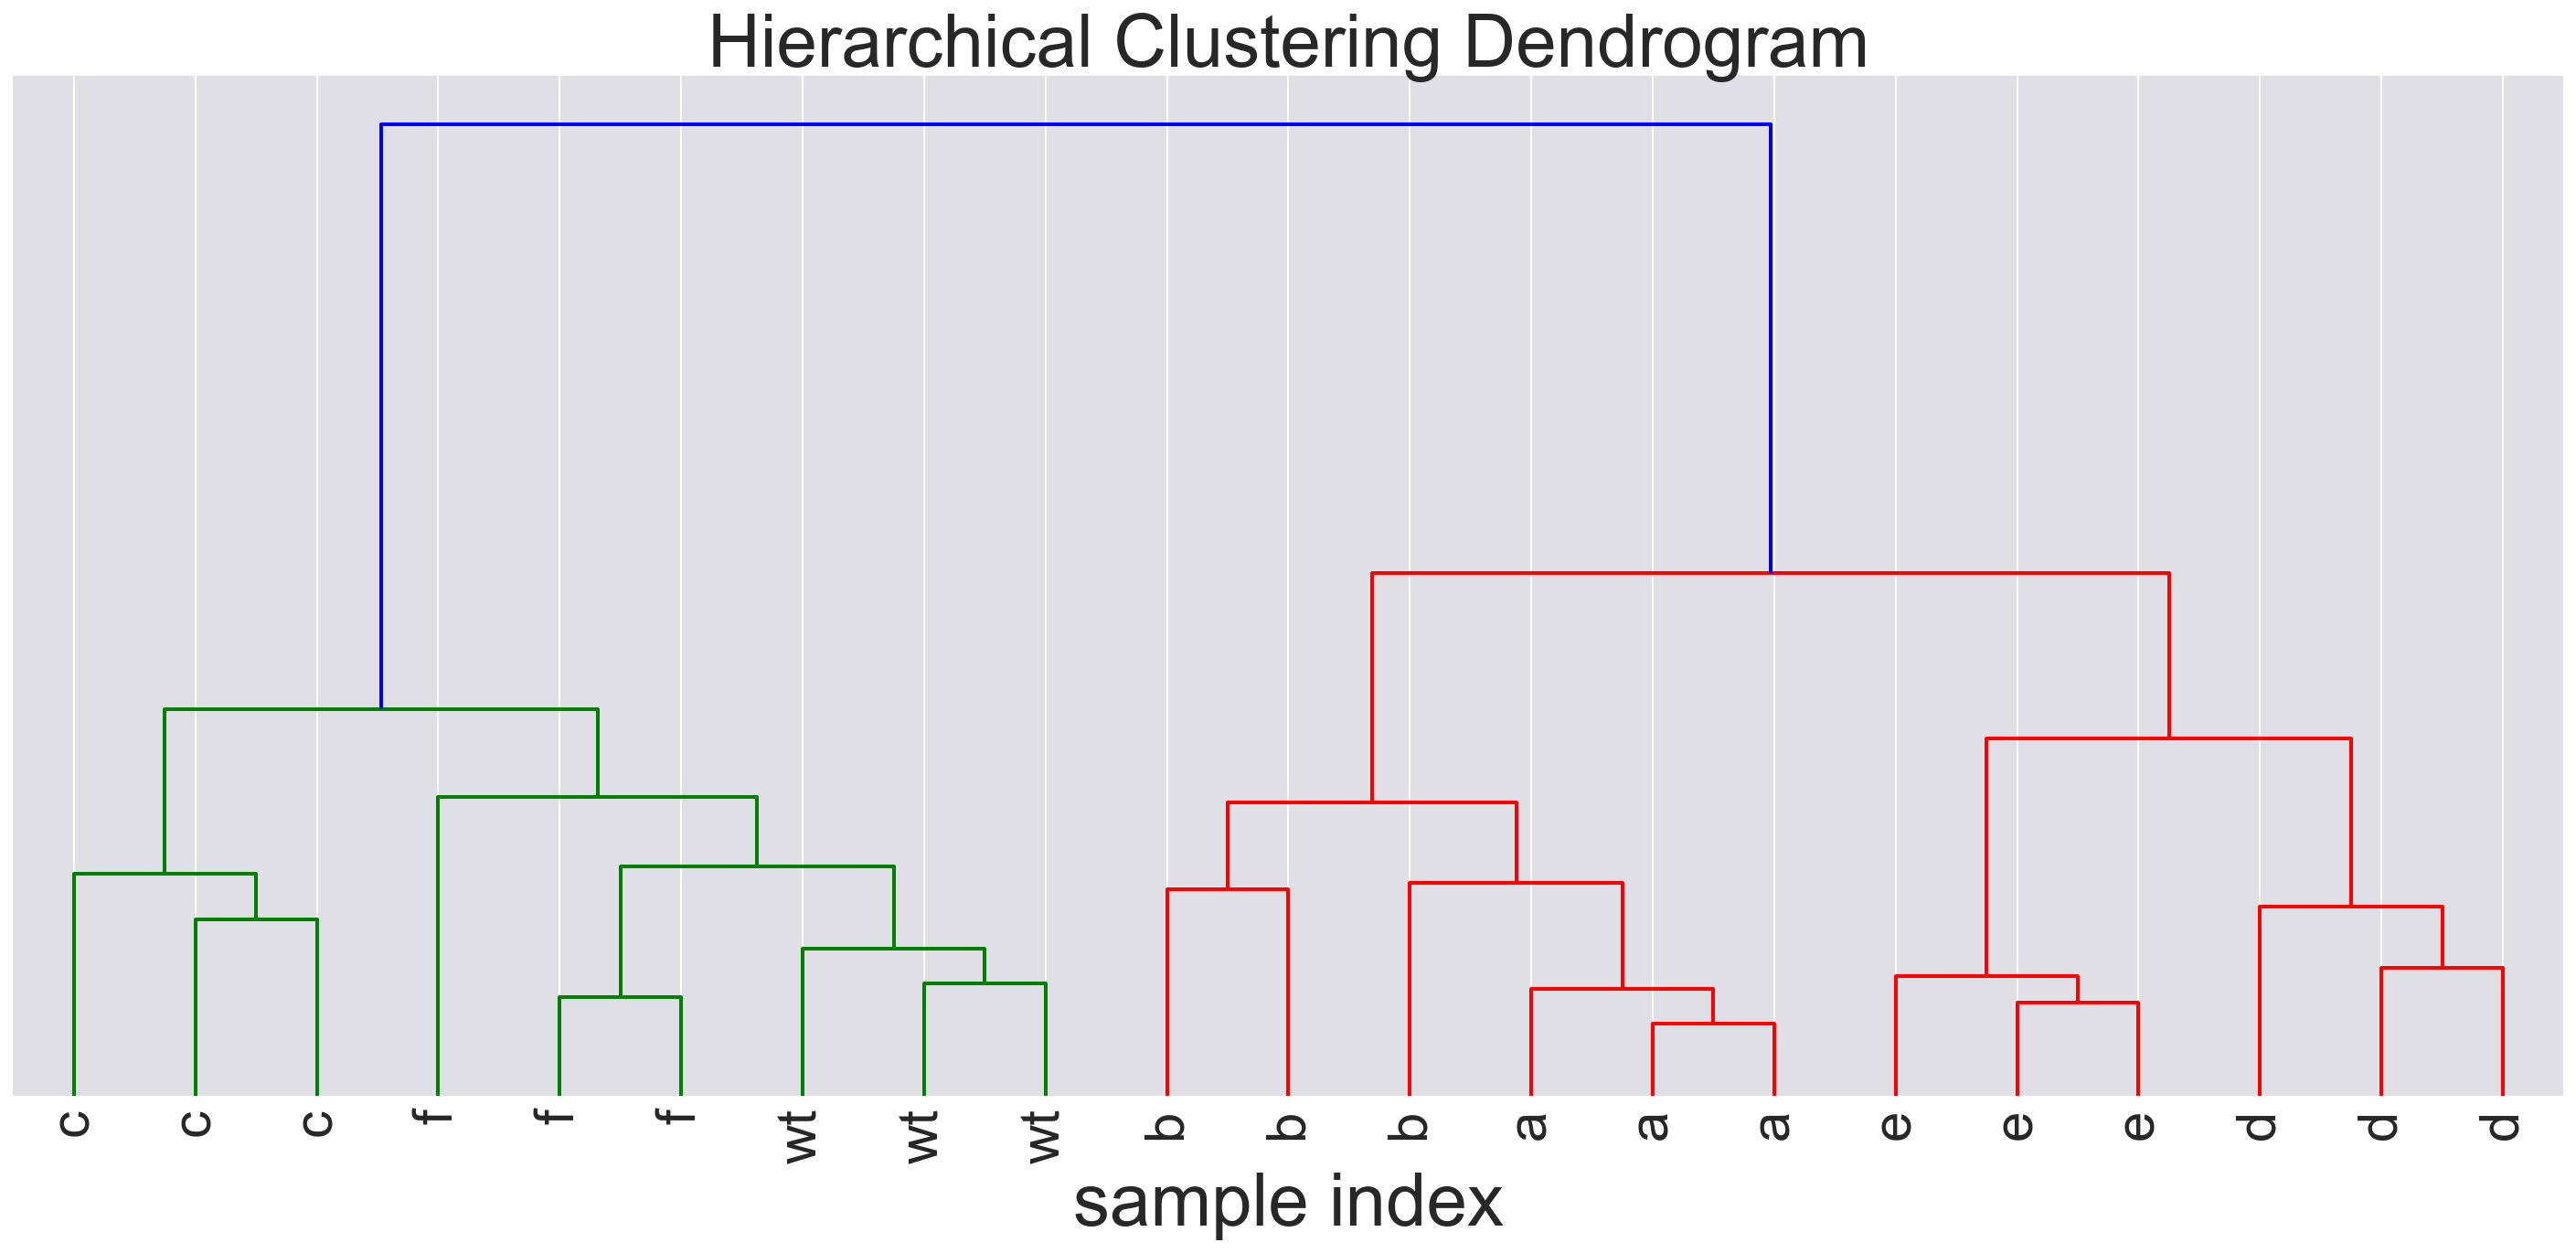

In [34]:
model = linkage(sklearn_pca.transform(pca_matrix), 'ward')

plt.figure(figsize=(25, 10))
dendrogram(
    model,
    truncate_mode='level',  # show only the last p merged clusters
    labels=df_nD.genotypes.values,
    p=21,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.xticks(fontsize=30)
plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.yticks(fontsize=30)
plt.title('Hierarchical Clustering Dendrogram', fontsize=40)
plt.xlabel('sample index', fontsize=40)
# plt.ylabel('distance', fontsize=40)

In [14]:
# Figure out what genes are in 10% or above expression in TPM for all samples. Delete anything below that...
names = ['']
for key, name in enumerate(tpm):
    # drop anything in the bottom 10%
    min_tpm= (tpm[name].tpm < tpm[name].tpm.quantile(.1)) 
    # drop anything that has 0 tpm
    zero = (tpm[name].tpm == 0)
    # find those ids:
    series = tpm[name][min_tpm | zero].target_id
    names = names + pd.Series.tolist(series)

#find the set of names (no repetitions) that don't pass the filter
names = list(set(names))
names = names[1:]
len(names)


17010

In [15]:
na = []
for key, genotype in enumerate(beta):
    # replace beta dfs with filtered values also
    beta[genotype] = beta[genotype][~beta[genotype].target_id.isin(names)]
    not_dropped = beta[genotype].dropna(axis=0, subset=['b']).target_id.values
    na_here = beta[genotype][~beta[genotype].target_id.isin(not_dropped)].target_id.values
    na = na + pd.Series.tolist(na_here)

na = list(set(na))
print('Number of na genes: {0}'.format(len(na)))

# filter everything that has beta == nan
beta_filtered = {}
tpm_filtered = {}
for key, name in enumerate(tpm):
    # replace tpm dfs with the filtered values:
    filter1 = (~tpm[name].target_id.isin(names))
    temp =  tpm[name][filter1]
    filter2 = (~temp.target_id.isin(na))
    temp2 = temp[filter2]
    tpm_filtered[name] = temp2.copy()

for key, genotype in enumerate(beta):
    # replace beta dfs with filtered values also
    filter1 = (~beta[genotype].target_id.isin(names))
    temp =  beta[genotype][filter1]
    filter2 = (~temp.target_id.isin(na))
    temp2 = temp[filter2]
    beta_filtered[genotype] =temp2.copy()


Number of na genes: 981


The first 3 principal components explain >=90% of the data


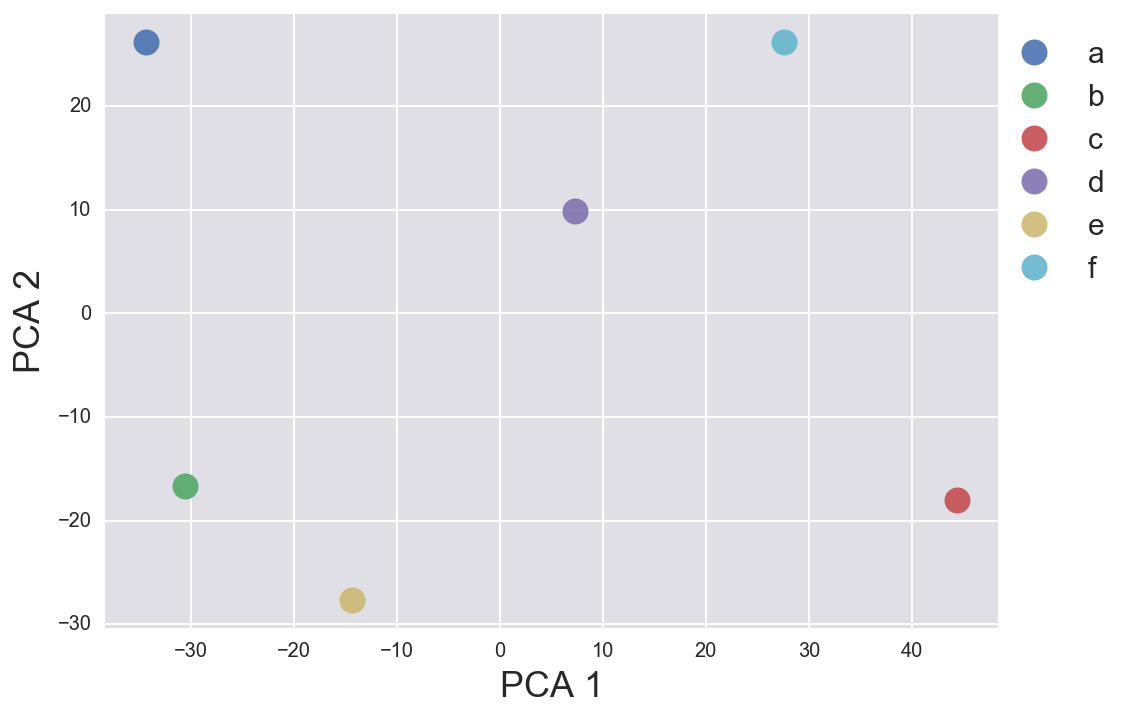

In [16]:
# PCA
pca_matrix = genpy.make_matrix(beta_filtered, genmap[genmap.genotype != 'wt'], 'genotype', 'b')
sklearn_pca, n = genpy.pca(pca_matrix)
# keep only the first principal components that explain 90% of the data
df_nD = genpy.tidy_pca(pca_matrix, n)

# # add a sample and genotype column
df_nD['genotypes'] = genmap[genmap.genotype != 'wt'].genotype.unique()
plot_2d_pca(df_nD, 'genotypes', 'wt', save='../output/preliminary_pca.pdf')

In [24]:
# lambda index function:
lind = lambda x: (x.qval < 0.1)

In [ ]:
# Spearman analysis
# size of the matrix is #genotypes - 3 (wt + 2 double mutants)
s = len(genmap.genotype.unique())
rho_matrix = np.empty(shape=(s-3, s-3))

l=0
for i in single_mutants:
    m= 0     
    for j in single_mutants:
        x = beta_filtered[i]
        y = beta_filtered[j]
        ovx = x[lind(x)]
        ovy = y[lind(y) & y.target_id.isin(ovx.target_id)]
        ovx = x[lind(x) & x.target_id.isin(ovy.target_id)]
        rho = stats.spearmanr(ovx.b, ovy.b)
        rho_matrix[l, m] = rho[0]
        m += 1
    l += 1

sns.heatmap(rho_matrix, xticklabels=single_mutants, yticklabels=single_mutants)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

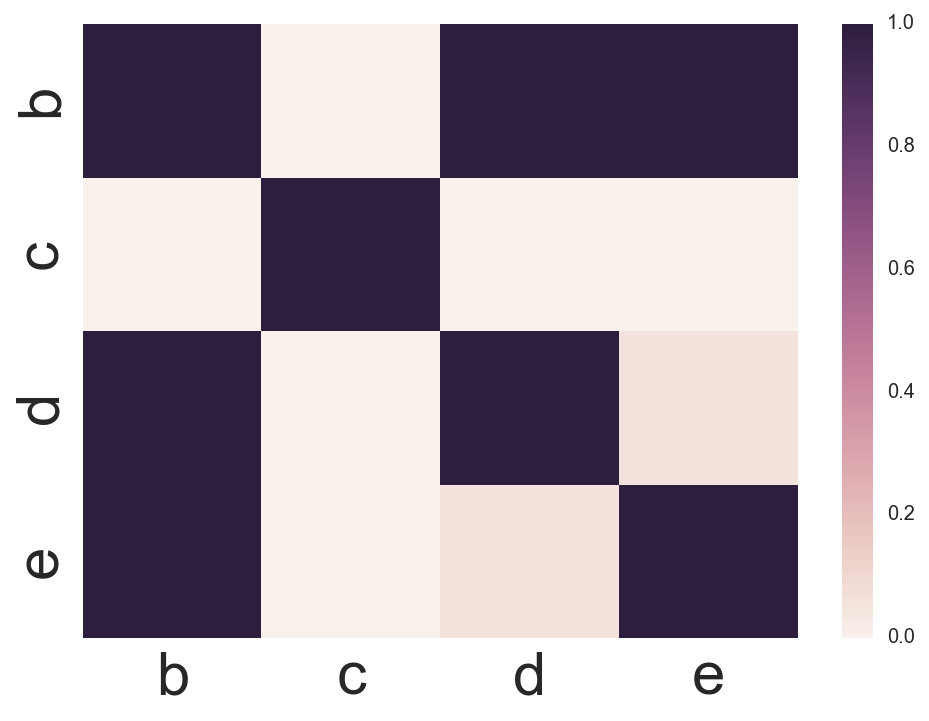

In [19]:
s = len(single_mutants)
plus_matrix = np.zeros(shape=(s, s))
overlap_plus_matrix = np.zeros(shape=(s, s))
minus_matrix = np.zeros(shape=(s, s))
overlap_minus_matrix = np.zeros(shape=(s, s))

l=0
for i in single_mutants:
    m= 0
    for j in single_mutants:
        x = beta_filtered[i]
        y = beta_filtered[j]
        
        # calculate the probability of interaction:
        overlap_pp, overlap_fp, expectedp, id_p = genpy.a_interacts_b(x, y, sign='+')        
        overlap_pm, overlap_fm, expectedm, id_m = genpy.a_interacts_b(x, y, sign='-')
        if i == j:
            overlap_plus_matrix[l, m] = 0
            overlap_minus_matrix[l, m] = 0
        else:
            overlap_plus_matrix[l, m] = overlap_fp
            overlap_minus_matrix[l, m] = overlap_fm

        plus_matrix[l, m] = overlap_pp
        minus_matrix[l, m] = overlap_pm
        m+=1
    l+=1

sns.heatmap(plus_matrix, xticklabels=single_mutants, yticklabels=single_mutants)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

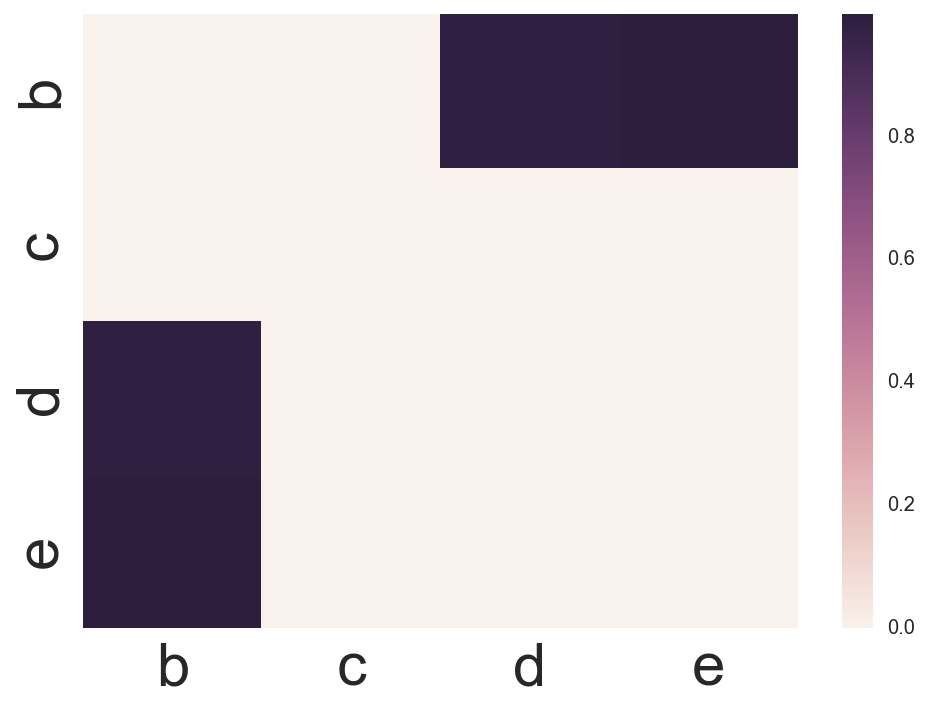

In [20]:
sns.heatmap(minus_matrix, xticklabels=single_mutants, yticklabels=single_mutants)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

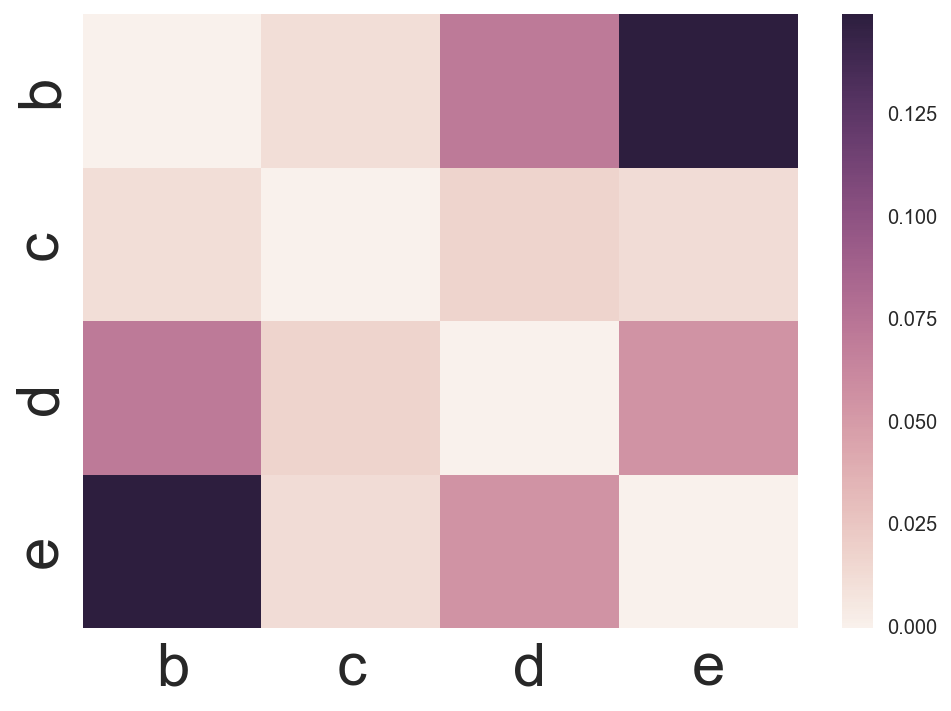

In [21]:
sns.heatmap(overlap_plus_matrix, xticklabels=single_mutants, yticklabels=single_mutants)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

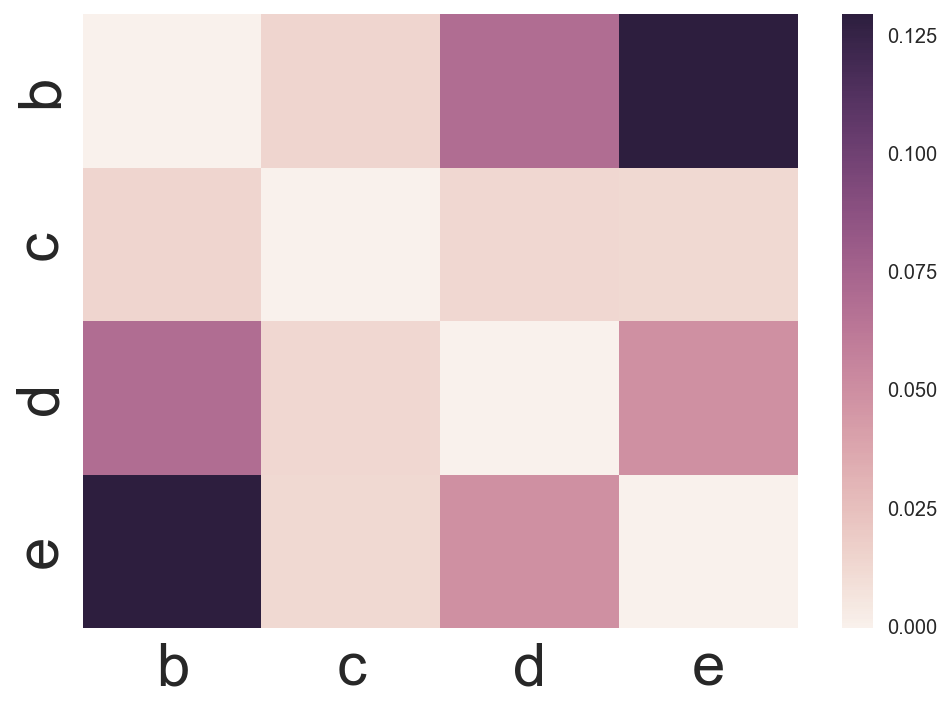

In [22]:
sns.heatmap(overlap_minus_matrix, xticklabels=single_mutants, yticklabels=single_mutants)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

f b 0.65
f d 0.47
a b 0.97
a c 0.041


(array([ 0.5,  1.5]), <a list of 2 Text yticklabel objects>)

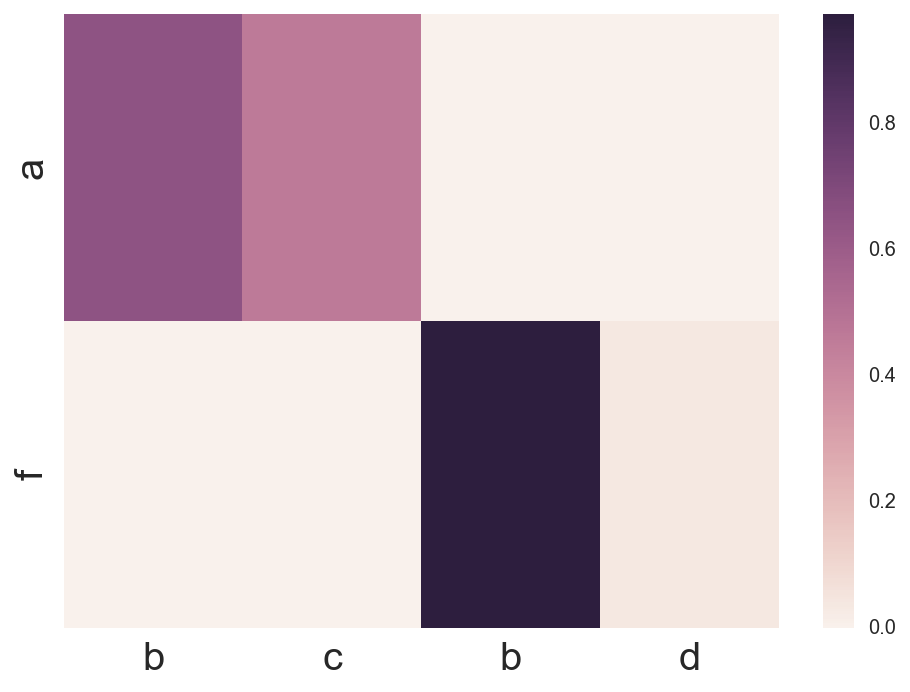

In [25]:
rho_matrix_doubles = np.zeros(shape=(2, 4))
l= 0
for key, i in enumerate(double_mutants):    
    m= 0     
    if l == 1:
        m += 2
    for j in double_mutants[i]:
        
        x = beta_filtered[i]
        y = beta_filtered[j]
        ovx = x[lind(x)]
        ovy = y[lind(y) & y.target_id.isin(ovx.target_id)]
        ovx = x[lind(x) & x.target_id.isin(ovy.target_id)]
        rho = stats.spearmanr(ovx.b, ovy.b)
        rho_matrix_doubles[l, m] = rho[0]
        print(i, j, '{0:.2g}'.format(rho[0]))
        m += 1
    l += 1

sns.heatmap(rho_matrix_doubles, xticklabels=['b', 'c','b','d'], yticklabels=['a', 'f'])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)